In [9]:
# import the libraries
import pandas as pd
import numpy as np
import glob
import os

import matplotlib.pyplot as plt
import seaborn as sns



In [10]:
files = glob.glob("../data/*.csv")
print("Files found:", files)

df_list = []

for file in files:
    print("Reading:", file)
    df = pd.read_csv(file, low_memory=False)
    df_list.append(df)

df = pd.concat(df_list, ignore_index=True)
print("Final Shape:", df.shape)


Files found: ['../data\\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', '../data\\Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', '../data\\Friday-WorkingHours-Morning.pcap_ISCX.csv', '../data\\Monday-WorkingHours.pcap_ISCX.csv', '../data\\Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', '../data\\Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', '../data\\Tuesday-WorkingHours.pcap_ISCX.csv', '../data\\Wednesday-workingHours.pcap_ISCX.csv']
Reading: ../data\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Reading: ../data\Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Reading: ../data\Friday-WorkingHours-Morning.pcap_ISCX.csv
Reading: ../data\Monday-WorkingHours.pcap_ISCX.csv
Reading: ../data\Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Reading: ../data\Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Reading: ../data\Tuesday-WorkingHours.pcap_ISCX.csv
Reading: ../data\Wednesday-workingHours.pcap_ISCX.csv
Final Shape: (2830743, 7

In [11]:
# Strip column names
df.columns = df.columns.str.strip()

# Replace inf with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop missing rows
df.dropna(inplace=True)

print("After cleaning:", df.shape)


After cleaning: (2827876, 79)


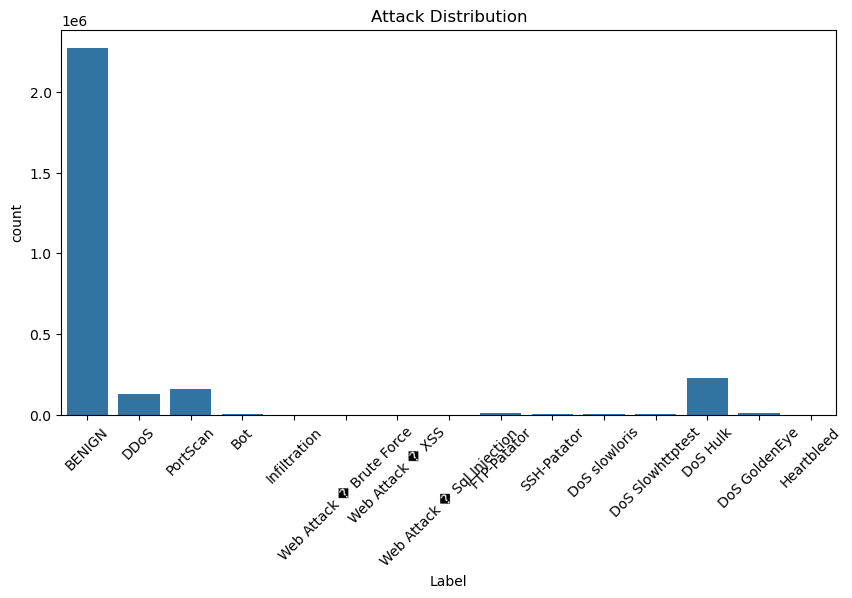

In [12]:
plt.figure(figsize=(10,5))
sns.countplot(x="Label", data=df)
plt.xticks(rotation=45)
plt.title("Attack Distribution")
plt.show()


In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["Label_encoded"] = le.fit_transform(df["Label"])

# Save mapping (for understanding)
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
label_mapping


{'BENIGN': np.int64(0),
 'Bot': np.int64(1),
 'DDoS': np.int64(2),
 'DoS GoldenEye': np.int64(3),
 'DoS Hulk': np.int64(4),
 'DoS Slowhttptest': np.int64(5),
 'DoS slowloris': np.int64(6),
 'FTP-Patator': np.int64(7),
 'Heartbleed': np.int64(8),
 'Infiltration': np.int64(9),
 'PortScan': np.int64(10),
 'SSH-Patator': np.int64(11),
 'Web Attack � Brute Force': np.int64(12),
 'Web Attack � Sql Injection': np.int64(13),
 'Web Attack � XSS': np.int64(14)}

In [14]:
X = df.drop(["Label", "Label_encoded"], axis=1)
y = df["Label_encoded"]

print("Features shape:", X.shape)
print("Target shape:", y.shape)


Features shape: (2827876, 78)
Target shape: (2827876,)


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [16]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [17]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))



Accuracy: 0.9986226431107402
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    454265
           1       0.88      0.76      0.81       391
           2       1.00      1.00      1.00     25605
           3       1.00      0.99      1.00      2059
           4       1.00      1.00      1.00     46025
           5       0.99      0.99      0.99      1100
           6       1.00      1.00      1.00      1159
           7       1.00      1.00      1.00      1587
           8       1.00      1.00      1.00         2
           9       1.00      0.57      0.73         7
          10       0.99      1.00      0.99     31761
          11       1.00      1.00      1.00      1180
          12       0.74      0.81      0.77       301
          13       1.00      0.25      0.40         4
          14       0.45      0.35      0.39       130

    accuracy                           1.00    565576
   macro avg       0.94      0.85      0.87    5655

In [18]:
import joblib

# Create directories
os.makedirs("../model", exist_ok=True)
os.makedirs("../analysis/model", exist_ok=True)

# Save trained model
joblib.dump(model, "../model/model.pkl")

# Save feature order
joblib.dump(X.columns.tolist(), "../analysis/model/features.pkl")

# ⭐ Save label encoder (THIS ENABLES REAL ATTACK NAMES)
joblib.dump(le, "../analysis/model/label_encoder.pkl")

print("Model, features & label encoder saved successfully")


Model, features & label encoder saved successfully


In [19]:
# Reload everything
model_loaded = joblib.load("../model/model.pkl")
features_loaded = joblib.load("../analysis/model/features.pkl")
le_loaded = joblib.load("../analysis/model/label_encoder.pkl")

# Predict one sample
sample = X.iloc[[0]]
pred = model_loaded.predict(sample)

# Decode prediction
attack_name = le_loaded.inverse_transform(pred)
attack_name



array(['BENIGN'], dtype=object)